# **Article Results - Power Dataset**

The dataset ("_PowerWithOutliers.xlsx_") we are examining is the same one used in the notebook titled "#01 - Explaining the TEDA Algorithm". Just as we did there, we are inserting virtual outliers in the curve to test our TEDA RLS algorithm.
This dataset simulates real distribution substation power data, providing measurements of active power every 15 minutes, totaling 96 measurements per day. The dataset covers 10 consecutive days.

## 1. Modules import

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import plotly.express as px
from random import randint, sample


#### Importing our modules:

In [3]:
from teda import TEDA
from RLSFilter import RLSFilter

## 2. Data import

### 2.1 Power data:

In [4]:
data = pd.read_excel("PowerWithOutliers.xlsx")
data.head()

,Date,Hour,P,label,P with outliers
0,2010-01-01,00:00:00,770.0,0,770.0
1,2010-01-01,00:15:00,754.0,0,754.0
2,2010-01-01,00:30:00,754.0,0,754.0
3,2010-01-01,00:45:00,724.0,0,724.0
4,2010-01-01,01:00:00,724.0,0,724.0


#### Time stamp:

In [5]:
ts = np.linspace(0, len(data)/96, len(data))

### Let's see the Power Curve with outliers

In [6]:
figure = make_subplots(specs=[[{"secondary_y": True}]])

figure.update_layout(
    title="Power Dataset with Outliers"
)

figure.add_trace(
    go.Scatter(x = ts, y=data['P'], name='True'),
    secondary_y=False
)

figure.add_trace(
    go.Scatter(x = ts, y=data['P with outliers'], name='With outliers'),
    secondary_y=False
)

figure.update_xaxes(title='Time (days)')
figure.update_yaxes(title='P (MW)', secondary_y=False)
figure.show()

## 3. Running on Python:

### Defining algorithm instances:

In [7]:
#TEDA
teda = TEDA(threshold=2.35)
FLAG = []

#RLS
filter_order = 2                    # Filter_order equivalent to window size
forgetting_factor = 0.99            # Forgetting factor: It is introduced to give exponentially less weight to older error samples. It is usually chosen between 0.98 and 1.
regularization_factor = 0.1         # It is usually chose between 0.1 and 1.
w0 = [0.0, 0.0]                     # Initial weights
X_ant = [0.0, 0.0]                  # Initial previous input
rls_filter = RLSFilter(n = filter_order, mu = forgetting_factor, delta=regularization_factor, w=w0) #Defining the filter instance
N_outlier_max = 1                   # Maximum of outliers corrected by TEDARLS
correction = True                   # Consecutive outlier correction flag

#### Defining auxiliary variables:

In [8]:
Ya_py = []          # Vector of auxiliary predicted values
Y_py = []           # Vector of predicted values
DB = []             # Vector of saved values (database)
outlier_count = 0   # Outlier count 
y_pred_py = 0.0     #Initial predicted value

### Running:

In [9]:
for i in data['P with outliers']:
    ## Acquiring the data input
    valor_atual = i

    #Checking if it is an outlier
    flag = teda.run(valor_atual)
    FLAG.append(flag)

    ## First Stage: Correcting outlier
    if (flag == 1):       
        outlier_count = outlier_count + 1
        valor_atual = y_pred_py
    else:
        outlier_count = 0
      
    #Evaluating the flood of outliers
    if(correction == True and outlier_count == N_outlier_max + 1):
        valor_atual = i
    
    #Saving 
    Ya_py.append(y_pred_py)

    # Updating weights
    rls_filter.update(valor_atual, np.array(X_ant))
    input_vector = []
    for j in X_ant[1:]:
        input_vector.append(j)
    input_vector.append(valor_atual)

    #Predicting the next value
    y_pred_py = rls_filter.filter(input_vector)
    Y_py.append(y_pred_py)

    # Second stage
    if (flag == 1):
        valor_atual = y_pred_py

    if(correction == True and outlier_count == N_outlier_max + 1):
        outlier_count = 0
        valor_atual = i
    DB.append(valor_atual)

    #Updating previous values vector
    X_ant = input_vector

data['flag_py'] = FLAG
data['save_py'] = DB
data['ya_pred_py'] = Ya_py
data['y_pred_py'] = Y_py

## 4. Visualization:

### 4.1 TEDA

In [10]:
def find_indices(list_to_check, item_to_find):
    indices = []
    for idx, value in enumerate(list_to_check):
        if value == item_to_find:
            indices.append(idx)
    return indices

In [11]:
numberOfOutliersPython = data['flag_py'].sum()
numberOfOutliersPython

59

In [12]:
outliersIndexPython = find_indices(data['flag_py'], 1)
outliersIndexPython

[39,
 72,
 73,
 74,
 75,
 76,
 77,
 78,
 81,
 84,
 94,
 170,
 171,
 172,
 189,
 284,
 289,
 361,
 362,
 363,
 364,
 365,
 366,
 371,
 383,
 442,
 459,
 460,
 461,
 462,
 511,
 521,
 536,
 554,
 555,
 556,
 558,
 566,
 567,
 571,
 589,
 630,
 669,
 709,
 726,
 745,
 746,
 747,
 748,
 827,
 832,
 842,
 843,
 844,
 879,
 896,
 919,
 933,
 938]

### TEDA Chart

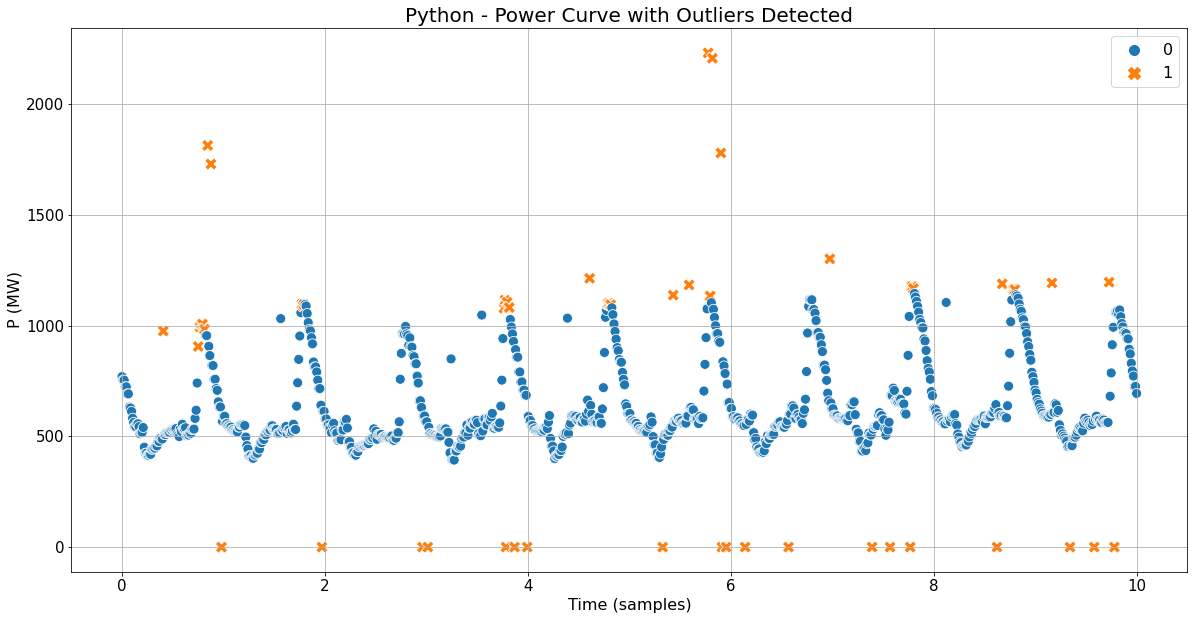

In [13]:
plt.figure(figsize=(20,10))
plt.grid()
plt.title("Python - Power Curve with Outliers Detected", fontsize=20)
sns.scatterplot(x=ts, y=data['P with outliers'], hue=data['flag_py'], style=data['flag_py'], size=data['flag_py'], sizes=(150, 100))
plt.legend(fontsize=16)
plt.ylabel("P (MW)", fontsize=16)
plt.xlabel("Time (samples)", fontsize=16)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.show()

### 4.2 RLS

In [14]:
figure = make_subplots(specs=[[{"secondary_y": True}]])

figure.update_layout(
    title="Power Dataset"
)

figure.add_trace(
    go.Scatter(x=ts, y=data['P'], name='True'),
    secondary_y=False
)

figure.add_trace(
    go.Scatter(x=ts, y=data['P with outliers'], name='With outliers'),
    secondary_y=False
)

figure.add_trace(
    go.Scatter(x=ts, y=data['y_pred_py'], name='Predicted'),
    secondary_y=False
)

figure.add_trace(
    go.Scatter(x=ts, y=data['save_py'], name='Saved'),
    secondary_y=False
)


figure.update_xaxes(title='Time (days)')
figure.update_yaxes(title='P (MW)', secondary_y=False)
figure.show()

# 5. Metrics

In this section, we will present the metrics for the TEDA classification algorithm, including the **classification report** and **confusion_matrix**, as well as for the RLS forecasting algorithm, which includes the **Mean Squared Error** (MSE) and **Mean Absolute Error** (MAE).

### 5.1 TEDA Evaluation

In [15]:
from sklearn.metrics import classification_report, confusion_matrix

#### 5.1.1 Confusion matrix:

$$
CM = \begin{bmatrix}
TN & FP\\ 
FN & TP
\end{bmatrix}
$$

In [16]:
print(confusion_matrix(data['label'], data['flag_py']))

[[896  27]
 [  5  32]]


#### 5.1.2 Classification report:

In [17]:
print(classification_report(data['label'], data['flag_py']))

              precision    recall  f1-score   support

           0       0.99      0.97      0.98       923
           1       0.54      0.86      0.67        37

    accuracy                           0.97       960
   macro avg       0.77      0.92      0.82       960
weighted avg       0.98      0.97      0.97       960



### 5.2 RLS Evaluation
The MSE metric will be applied between the current values and the values corrected/saved by the algorithm, as well as between the current values and the values predicted by the RLS algorithm.

In [18]:
from sklearn.metrics import mean_squared_error, mean_absolute_error

#### 5.2.1 Comparing to Saved Values

In [26]:
start = 0

Root Mean Squared Error (RMSE)

In [27]:
rmse_saved = mean_squared_error(data['P with outliers'].iloc[start:], data['save_py'].iloc[start:], squared=False)
rmse_saved

131.80336161601087

Mean Absolute Error (MAE)

In [28]:
mae_saved = mean_absolute_error(data['P with outliers'].iloc[start:], data['save_py'].iloc[start:])
mae_saved

23.331087991978357

#### 5.2.2 Comparing to Predicted Values

Root Mean Squared Error (RMSE)

In [34]:
rmse_pred = mean_squared_error(data['P with outliers'].iloc[start:], data['y_pred_py'].iloc[start:], squared=False)
rmse_pred

134.19210322291326

Mean Absolute Error (MAE)

In [35]:
mae_pred = mean_absolute_error(data['P with outliers'].iloc[start:], data['y_pred_py'].iloc[start:])
mae_pred

27.611500453551084

# 6. References

 [[1]](https://www.mdpi.com/1424-8220/22/10/3838) **Andrade, P.**; Silva, I.; Silva, M.; Flores, T.; Cassiano, J.; Costa, D.G. *A TinyML Soft-Sensor Approach for Low-Cost Detection and Monitoring of Vehicular Emissions*. SENSORS 2022, 22, 3838.  ![GitHub](https://img.shields.io/badge/DOI-10.3390%2Fs22103838-green)


[[2]](https://dl.acm.org/journal/tecs) **Andrade, P.**; Silva, I.; Silva, M.; Flores, T.; Costa, D.G. Soares, E.; _Online Processing of Vehicular Data on the Edge Through an Unsupervised TinyML Regression Technique_. ACM TECS 2023. ![GitHub](https://img.shields.io/badge/DOI-10.1145%2Fs3591356-green)